In [1]:
from wealth_process_V_opt import *
from mining_network_simulation import *
from optim import *
from decimal import *
import math as ma
import pandas as pd
import seaborn as sns
import warnings
import time

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Network of miners

The overall discovery rate of the network is 
$$
\lambda = 6
$$

blocks per hour. This is the sum of the discovery rate of the miners $\lambda_1,\ldots, \lambda_m$ such that 

$$
\sum_{l = 1}^m\lambda_l = \lambda
$$

We therefore sample the discovery rates as 

$$
(\lambda_1,\ldots, \lambda_m) = \lambda \cdot (w_1,\ldots, w_m),
$$

where $(w_1,\ldots, w_m) \sim \text{Dirichlet}(1,\ldots, 1)$. Depending on their mining equipment and their location, miners will have varying operational cost defined as 

$$c_l = \lambda_l \cdot b / (1 + \eta_l),$$

where the $\eta_l>0$ corresponds to the expected profitability per time unit that we randomize as

$$
\eta_l \sim \text{Unif}([0.05, 0.3])
$$

to account for the heterogeneity among the miners. We further set the initial reserve depending on how much risk miners are ready to undertake and so the initial reserves is set so that 

$$
\psi_l(x_l) = \beta_l,\text{ for }l = 1,\ldots, m,
$$

where $\psi_l$ is the ruin probability of miner $i$ and we randomize $\beta_l \sim\text{Beta}(1.5, 1.5)$.




In [22]:
np.random.seed(142)  # for reproducibility
lam ,b = 6, 3.125 # block discovery rate of the network and reward for finding a block
m = 25
# Rate of discovery by the network is 6 blocks per hour and the block finding reward is 3.125
lam_m = lam * np.random.dirichlet(np.ones(m))  # share of the discovery rate for each pool
eta_low, eta_high = 0.04, 0.1  # range for the share of the reward for each pool
eta_m = np.random.uniform(eta_low, eta_high, m)  # share of the reward for each pool
c_m = lam_m * b / (1 + eta_m)  # operational cost per time unit (profitability on average)
X_m = [wealth_process(lam_l, b, c, 0, 1) for lam_l, c in zip(lam_m, c_m)]
a_beta, b_beta = 1.5, 1.5
beta_m = np.random.beta(a_beta, b_beta, m)
print(beta_m)  # print beta_m with 2 decimal places
x_m = np.array([sc.optimize.root_scalar(lambda x: X.ruin_proba(x) - beta, bracket=[0.01, 1000], method='bisect').root for X, beta in zip(X_m, beta_m)])


[0.86935435 0.79880575 0.76536174 0.06330428 0.52472347 0.19013971
 0.5076356  0.66749897 0.92744404 0.73081914 0.18006778 0.41782161
 0.93894867 0.53315952 0.85056706 0.59654517 0.77597026 0.23475155
 0.84323848 0.30462536 0.79032418 0.34663813 0.38221258 0.14945891
 0.24785751]


# Network of mining pools

The miners can invest their computing ressources in $n$ mining pools with caracteristics $(f_1, \delta_1), \ldots, (f_n, \delta_n)$. The miners can also mine solo which is equivalent to mine for mining pool $\#0$ with caracteristics $f_0 = 0$ and $\delta_0 = 1$. We randomize the pool fees with 

$$
f_k\sim \text{Unif}([0, 0.04])\text{ for }k=1,\ldots, n.
$$

We then tune the difficulty reduction so that the expected discounted of an average miner in the network is the same for all the mining pools

In [23]:
np.random.seed(42)  # for reproducibility
# Average miner
lam_bar = lam / m
c_bar = lam_bar * b / (1+ (eta_low + eta_high) / 2)  # average operational cost per time unit
x_bar = sc.optimize.root_scalar(lambda x: wealth_process(lam_bar, b, c_bar, 0, 1).ruin_proba(x) - a_beta/ (a_beta+ b_beta), bracket=[0.01, 1000], method='bisect').root
print(c_bar, lam_bar, lam_bar * b / c_bar, x_bar)
q = 0.03
X_bar = wealth_process(lam_bar, b, c_bar, 0, 1)
V_bar = X_bar.V(x_bar,q)[1]
V_bar



# # # Use the adjusted lower bound in the root_scalar method
# # return(sc.optimize.root_scalar(obj, bracket=[lower_bound, 1], method='brentq').root)
def return_δ(f):
    def obj(δ):
        X_pool = wealth_process(lam_bar / δ, (1 - f)*b * δ, c_bar, 0, 1)
        return(X_pool.V(x_bar, q)[1] - V_bar)
    lower_bound = 1
    while obj(lower_bound) < 0:
        lower_bound -= 0.01
    # print(obj(0.01), obj(1))
     
    return(sc.optimize.root_scalar(obj, bracket=[lower_bound, 1], method='brentq').root)

n = 10
f_n = np.insert(np.sort(np.random.uniform(0, 0.04, n)), 0, 0)
d_n = np.array([return_δ(f) for f in f_n])
f_n, d_n

0.7009345794392523 0.24 1.07 15.82488958246374


(array([0.        , 0.00232334, 0.00623978, 0.00624075, 0.0149816 ,
        0.02394634, 0.0240446 , 0.0283229 , 0.02927976, 0.03464705,
        0.03802857]),
 array([1.        , 0.69822091, 0.44496501, 0.44492224, 0.20431494,
        0.09485305, 0.0940298 , 0.06355297, 0.05799448, 0.03346297,
        0.02269206]))

Mean-variance trade off and expected utility based criterias require to select a risk aversion parameter that we randomize

$$
\gamma_k\sim\text{Unif}(0, 1),\text{ for }k = 1,\ldots, m
$$

When using the mean-variance efficient frontier the level of risk is set so that the targeted variance is 

$$
\tilde{\sigma}^2_l = \underset{k = 1,\ldots, n}{\min} \sigma^2_{k,l}\gamma_l + (1-\gamma_l) \cdot \underset{k = 1,\ldots, m}{\max} \sigma^2_{k,l}
$$

where $\sigma^2_{k,l}$ is the variance of the wealth process of miner $l$ when mining in pool $k$.

In [24]:
gam_m = np.random.uniform(0.1, 0.9, m)

## Miners hashpower location

We provide the information of how each miner is allocating her hashpower

In [25]:
network_mean_variance_frontier = miner_hashpower_allocate(c_m, lam_m, x_m, gam_m, b, f_n, d_n, q,  m, criteria='mean variance frontier')
network_mean_variance_utility = miner_hashpower_allocate(c_m, lam_m, x_m, gam_m, b, f_n, d_n, q, m, criteria='mean variance utility')
network_dividend = miner_hashpower_allocate(c_m, lam_m, x_m, gam_m, b, f_n, d_n, q, m, criteria='dividend')


## Distribution of hashpower among the pool

Based on the allocation of miners, we deduce the hashpower distribution among the mining pool. 

In [26]:
hashpower_df_mean_variance_frontier = mining_pool_hashpower_distribute(network_mean_variance_frontier, n)
hashpower_df_mean_variance_utility = mining_pool_hashpower_distribute(network_mean_variance_utility, n)
hashpower_df_dividend= mining_pool_hashpower_distribute(network_dividend, n)


## Visualization of the hashpower distribution

We can then do a pie plot to show the ditribution

In [27]:
def hashpower_pie_plot(hashpower_df):
    """
    Plots a pie chart of the hashpower distribution among mining pools.
    
    Parameters:
    hashpower_df (DataFrame): DataFrame containing 'Mining Pool' and 'Hashpower Proportion'.
    """
    
    # Ensure the DataFrame is not empty
    if hashpower_df.empty:
        print("No data to plot.")
        return
    
    # Set the figure size
    plt.figure(figsize=(10, 7))
    # Define colors for each slice
    colors = plt.cm.tab20c.colors
    # Filter out rows with zero hashpower proportion
    hashpower_df = hashpower_df[hashpower_df['Hashpower Proportion'] > 0]
    # Plot the pie chart with different colors and improved text placement
    plt.figure(figsize=(10, 7))
    wedges, texts, autotexts = plt.pie(hashpower_df['Hashpower Proportion'], labels=hashpower_df['Mining Pool'], autopct='%1.0f%%', startangle=0, colors=colors)

    # Improve text placement
    for text in texts + autotexts:
        text.set_fontsize(28)
        text.set_color('black')

    # plt.title('Hashpower Proportion by Mining Pool')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    # plt.show()

<Figure size 1000x700 with 0 Axes>

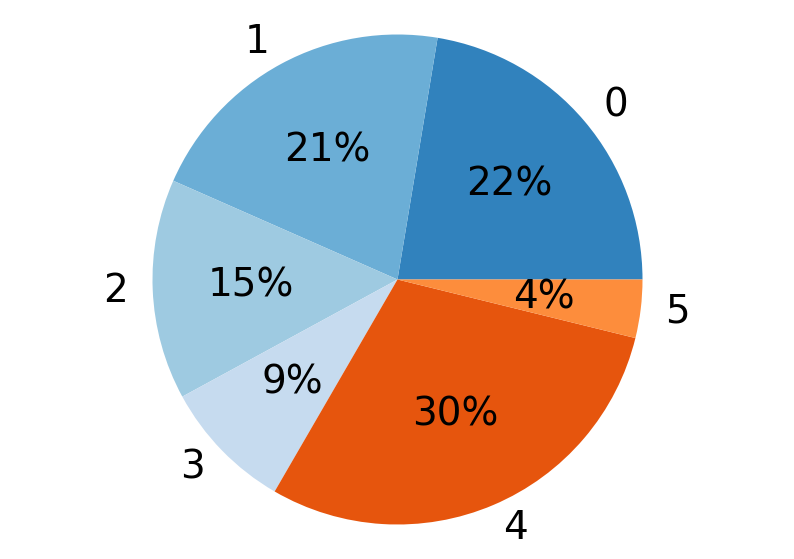

<Figure size 1000x700 with 0 Axes>

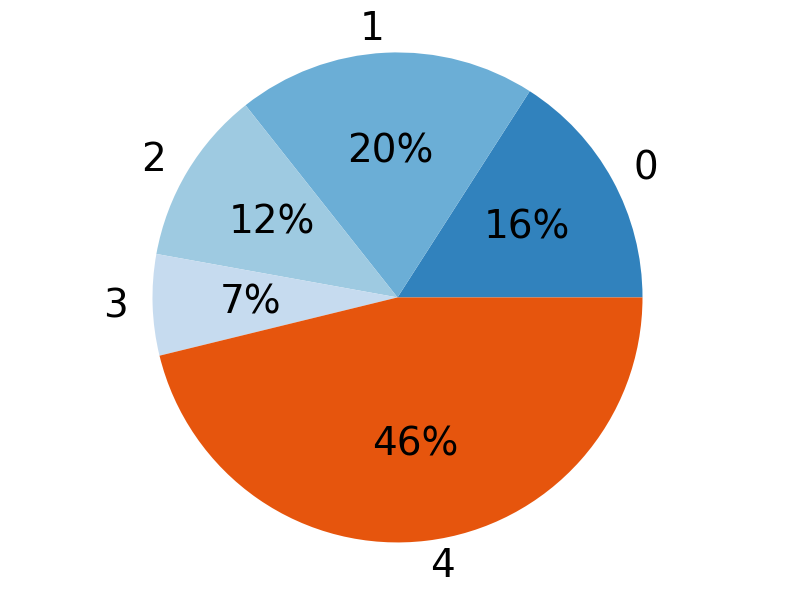

<Figure size 1000x700 with 0 Axes>

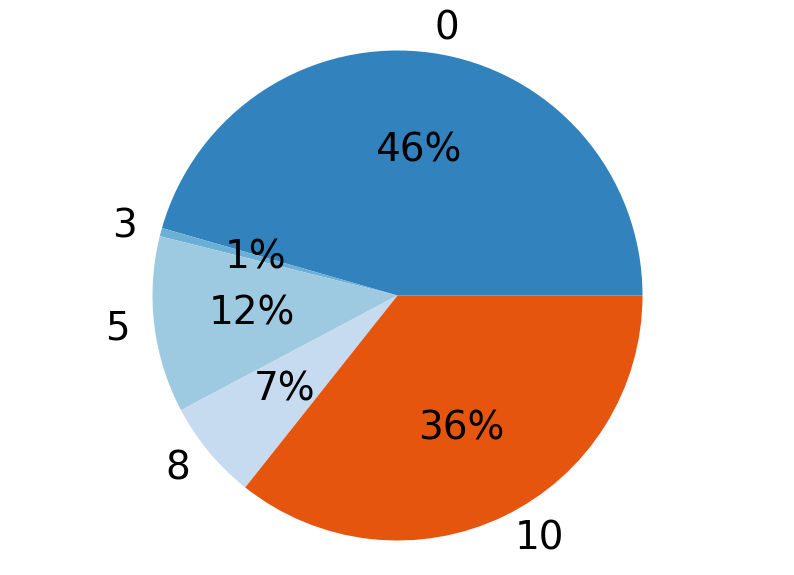

In [28]:
hashpower_pie_plot(hashpower_df_mean_variance_frontier)
plt.savefig('../Figures/pie_mean_variance_frontier.pdf', format='pdf')
hashpower_pie_plot(hashpower_df_mean_variance_utility)
plt.savefig('../Figures/pie_mean_variance_utility.pdf', format='pdf')
hashpower_pie_plot(hashpower_df_dividend)
plt.savefig('../Figures/pie_dividend.pdf', format='pdf')
